## **Αναγκαία πακέτα**

In [1]:
#imports

import networkx as nx
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from networkx.algorithms.centrality import *
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import random
import csv

## **Δημιουργία μοντέλου**

**Αλλαγές:** Αντικατάσταση του bridging centrality με το closeness centrality λόγω μεγάλου χρόνου εκτέλεσης του υπολογισμού. Αφαίρεση των clustering coefficient, και betweenness centrality για τον ίδιο λόγο. Αφαίρεση του eigenvector centrality λόγω αδυναμίας σύγκλισης σε ορισμένες περιπτώσεις.  

In [5]:
def generate_network_data(num_networks_per_type):
    data = []
    network_types = ["Erdos-Renyi", "Gilbert", "Random Geometric", "Watts Strogatz", "Barabasi Albert", "Waxman"]

    for network_type in network_types:
        count = 0
        while count < num_networks_per_type:
            if network_type == "Erdos-Renyi":
                g = nx.gnm_random_graph(random.randrange(1000, 2000), random.randrange(2000, 5000))
            elif network_type == "Gilbert":
                g = nx.gnp_random_graph(random.randrange(1000, 2000), random.uniform(0, 1))
            elif network_type == "Random Geometric":
                g = nx.random_geometric_graph(random.randrange(1000, 2000), random.uniform(0, 1))
            elif network_type == "Watts Strogatz":
                g = nx.watts_strogatz_graph(random.randrange(1000, 2000), random.randrange(1, 10), random.uniform(0, 1))
            elif network_type == "Barabasi Albert":
                g = nx.barabasi_albert_graph(random.randrange(1000, 2000), random.randrange(1, 10))
            elif network_type == "Waxman":
                g = nx.waxman_graph(random.randrange(1000, 2000), random.uniform(0, 1), random.uniform(0, 1))

            if not nx.is_connected(g):
                continue

            degree_distribution = np.array(list(dict(nx.degree(g)).values()))
            avg_path_length = nx.average_shortest_path_length(g)
            diameter = nx.diameter(g)
            information = list(nx.information_centrality(g).values())
            closeness = list(nx.closeness_centrality(g).values())
            harmonic = list(nx.harmonic_centrality(g).values())
            assortativity = nx.degree_assortativity_coefficient(g)

            features = [
                np.mean(degree_distribution),
                avg_path_length,
                diameter,
                np.mean(information),
                np.mean(closeness),
                np.mean(harmonic),
                assortativity
            ]

            data.append(features + [network_type])
            count += 1

    return pd.DataFrame(data, columns=["Degree Distribution", "Average Path Length", "Diameter", "Information Centrality", "Closeness Centrality", "Harmonic Centrality", "Assortativity", "Network Type"])

In [6]:
# Generate data
data = generate_network_data(100)
data.to_csv('network_data.csv')

In [2]:
#data insertion (when the data is already ready)
data = pd.read_csv('network_data.csv', index_col= 0)

In [3]:
#data preparation
X = data.drop("Network Type", axis=1)
y = data["Network Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Linear SVC**

In [9]:
model_lsvc = LinearSVC(random_state=42)
model_lsvc.fit(X_train.values, y_train)

y_pred_lsvc = model_lsvc.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred_lsvc)
precision = precision_score(y_test, y_pred_lsvc, average='macro')
recall = recall_score(y_test, y_pred_lsvc, average='macro')
f1 = f1_score(y_test, y_pred_lsvc, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Precision: 0.7576949112978525
Recall: 0.7607757137942897
Accuracy: 0.7583333333333333
F1-score: 0.7578914489628775


### **K Neighbours**

In [10]:
#k = sqrt(number of samples)/2
model_kn = KNeighborsClassifier(n_neighbors=12)
model_kn.fit(X_train.values, y_train)

y_pred_kn = model_kn.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred_kn)
precision = precision_score(y_test, y_pred_kn, average='macro')
recall = recall_score(y_test, y_pred_kn, average='macro')
f1 = f1_score(y_test, y_pred_kn, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Precision: 0.5935072055137844
Recall: 0.5805054516085609
Accuracy: 0.5833333333333334
F1-score: 0.5700094356510106


### **SVC**

In [11]:
model_svc = SVC(gamma='auto')
model_svc.fit(X_train.values, y_train)

y_pred_svc = model_svc.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc, average='macro')
recall = recall_score(y_test, y_pred_svc, average='macro')
f1 = f1_score(y_test, y_pred_svc, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Precision: 0.4728282828282829
Recall: 0.44233278742465715
Accuracy: 0.43333333333333335
F1-score: 0.39428177853874696


### **Ensemble**
Ada boost, Gradient boosting, random forests, bagging

In [12]:
#Ada boost
model_ada = AdaBoostClassifier(n_estimators=100, random_state=42)
model_ada.fit(X_train.values, y_train)

y_pred_ada = model_ada.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred_ada)
precision = precision_score(y_test, y_pred_ada, average='macro')
recall = recall_score(y_test, y_pred_ada, average='macro')
f1 = f1_score(y_test, y_pred_ada, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Precision: 0.7779307498057498
Recall: 0.6998925008599931
Accuracy: 0.7333333333333333
F1-score: 0.698400182056096


In [13]:
#Gradient Boosting
model_gr = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
model_gr.fit(X_train.values, y_train)

y_pred_gr = model_gr.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred_gr)
precision = precision_score(y_test, y_pred_gr, average='macro')
recall = recall_score(y_test, y_pred_gr, average='macro')
f1 = f1_score(y_test, y_pred_gr, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Precision: 0.9511784511784512
Recall: 0.9509502923976606
Accuracy: 0.95
F1-score: 0.9498129079835032


In [4]:
#Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train.values, y_train)

y_pred = model.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Precision: 0.9745370370370371
Recall: 0.9774758454106279
Accuracy: 0.975
F1-score: 0.975554538054538


In [15]:
#Bagging
model_bag = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=0)
model_bag.fit(X_train.values, y_train)

y_pred_bag = model_bag.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred_bag)
precision = precision_score(y_test, y_pred_bag, average='macro')
recall = recall_score(y_test, y_pred_bag, average='macro')
f1 = f1_score(y_test, y_pred_bag, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")

Precision: 0.5493587953265372
Recall: 0.5534596027579606
Accuracy: 0.5666666666666667
F1-score: 0.5356846498781983


## **Confusion Matrix**

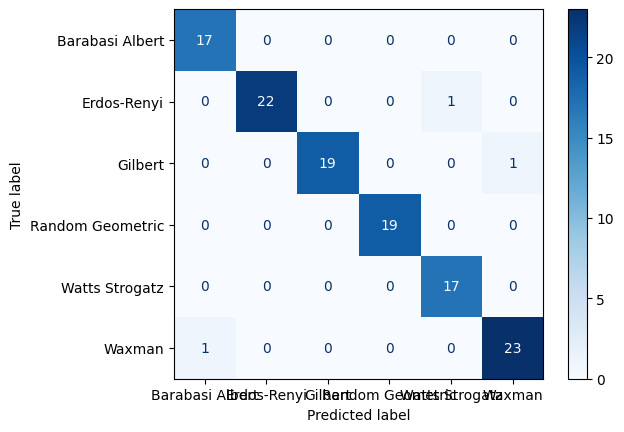

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

## **Ablation Study**

In [17]:
# Ablation study on features

def ablation_study(X_train, y_train, X_test, y_test):
    results = []
    features = X_train.columns.tolist()
    for i in range(len(features)):
        # Remove one feature at a time
        remaining_features = features[:i] + features[i+1:]
        X_train_ablated = X_train[remaining_features]
        X_test_ablated = X_test[remaining_features]

        # Train and evaluate the model
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train_ablated, y_train)
        y_pred = model.predict(X_test_ablated)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append({
            "removed_feature": features[i],
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        })

    return pd.DataFrame(results)


# Perform ablation study
ablation_results = ablation_study(X_train, y_train, X_test, y_test)
ablation_results

,removed_feature,accuracy,precision,recall,f1
0,Degree Distribution,0.975000,0.976754,0.975000,0.975282
1,Average Path Length,0.983333,0.984259,0.983333,0.983390
2,Diameter,0.966667,0.968259,0.966667,0.966604
3,Information Centrality,0.975000,0.976754,0.975000,0.975282
4,Closeness Centrality,0.983333,0.984259,0.983333,0.983390
5,Harmonic Centrality,0.983333,0.984259,0.983333,0.983390
6,Assortativity,0.791667,0.788154,0.791667,0.788812


## **Testing on real networks**

In [5]:
def extract_features(graph):
    #if not nx.is_connected(graph):
        #return None  # Handle disconnected graphs appropriately

    degree_distribution = np.array(list(dict(nx.degree(graph)).values()))
    avg_path_length = nx.average_shortest_path_length(graph)
    diameter = nx.diameter(graph)
    information = list(nx.information_centrality(graph).values())
    closeness = list(nx.closeness_centrality(graph).values())
    harmonic = list(nx.harmonic_centrality(graph).values())
    assortativity = nx.degree_assortativity_coefficient(graph)

    features = [
        np.mean(degree_distribution),
        avg_path_length,
        diameter,
        np.mean(information),
        np.mean(closeness),
        np.mean(harmonic),
        assortativity,
    ]
    return features

### **football**

In [20]:
football=nx.read_gml(r"football.gml")
football_features = extract_features(football)

In [21]:
if football_features is not None:
  football_features = np.array(football_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(football_features)
  print(f"Predicted Network Type for football data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the football graph.")

Predicted Network Type for football data: Waxman


### **got**

In [22]:
got=nx.Graph()
with open('got_s5.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    next(csv_reader)
    for row in csv_reader:
        got.add_edge(row[0],row[1])
        line_count += 1

got_features = extract_features(got)

In [23]:
if got_features is not None:
  got_features = np.array(got_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(got_features)
  print(f"Predicted Network Type for got data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the got graph.")

Predicted Network Type for got data: Barabasi Albert


### **email-eu**

In [24]:
#email-Eu-core network
eu=nx.read_edgelist("email-Eu-core.txt",create_using=nx.Graph)
#selecting the largest connected component
bc = max(nx.connected_components(eu), key=len)
beu = eu.subgraph(bc)

feu_features = extract_features(beu)

In [25]:
if feu_features is not None:
  feu_features = np.array(feu_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(feu_features)
  print(f"Predicted Network Type for email-eu data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the email-eu graph.")

Predicted Network Type for email-eu data: Waxman


### **Euroroad**

In [27]:
#Από ICON, ευρωπαϊκοί δρόμοι
euroroad=nx.read_edgelist("euroroad.txt",create_using=nx.Graph())

In [28]:
bc_e = max(nx.connected_components(euroroad), key=len)
b_e = euroroad.subgraph(bc_e)
euroroad_features = extract_features(b_e)

if euroroad_features is not None:
  euroroad_features = np.array(euroroad_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(euroroad_features)
  print(f"Predicted Network Type for euroroad data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the euroroad graph.")

Predicted Network Type for euroroad data: Watts Strogatz


### **ChicagoRegional**

In [31]:
#Από ICON, δρόμοι στο Σικάγο
chicago=nx.read_edgelist("ChicagoRegional.txt",create_using=nx.Graph())

In [32]:
bc_c = max(nx.connected_components(chicago), key=len)
b_c = chicago.subgraph(bc_c)

chicago_features = extract_features(b_c)

if chicago_features is not None:
  chicago_features = np.array(chicago_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(chicago_features)
  print(f"Predicted Network Type for chicago data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the chicago graph.")

Predicted Network Type for chicago data: Watts Strogatz


### **AdvogatoTrustNetwork**

In [34]:
#Από ICON, σχέσεις μεταξύ μελών του Advogato
advogato=nx.read_weighted_edgelist("advogato.txt",create_using=nx.Graph())

In [35]:
bc_a = max(nx.connected_components(advogato), key=len)
b_a = advogato.subgraph(bc_a)

advogato_features = extract_features(b_a)

if advogato_features is not None:
  advogato_features = np.array(advogato_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(advogato_features)
  print(f"Predicted Network Type for advogato data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the advogato graph.")

Predicted Network Type for advogato data: Barabasi Albert


### **Flights-FAA**

In [36]:
#Από ICON, πτήσεις του Federal Aviation Association
flights=nx.read_edgelist("flights-faa.txt",create_using=nx.Graph())

In [37]:
bc_f = max(nx.connected_components(flights), key=len)
b_f = flights.subgraph(bc_f)

flights_features = extract_features(b_f)

if flights_features is not None:
  flights_features = np.array(flights_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(flights_features)
  print(f"Predicted Network Type for flights data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the flights graph.")

Predicted Network Type for flights data: Watts Strogatz


### **Bristol**

In [38]:
#Από ICON, ΜΜΜ στο Bristol, είναι spatial
bristol = nx.read_edgelist("edges_bristol.txt", create_using=nx.Graph())

In [39]:
bc_b = max(nx.connected_components(bristol), key=len)
b_b = bristol.subgraph(bc_b)
bristol_features = extract_features(b_b)

if bristol_features is not None:
  bristol_features = np.array(bristol_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(bristol_features)
  print(f"Predicted Network Type for bristol data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the bristol graph.")

Predicted Network Type for bristol data: Watts Strogatz


### **Coach**

In [40]:
#Όπως το Bristol, αλλά για το Coach
coach=nx.read_edgelist("edges_coach.txt",create_using=nx.Graph())

In [41]:
bc_c = max(nx.connected_components(coach), key=len)
b_c = coach.subgraph(bc_c)
coach_features = extract_features(b_c)

if coach_features is not None:
  coach_features = np.array(coach_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(coach_features)
  print(f"Predicted Network Type for coach data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the coach graph.")

Predicted Network Type for coach data: Watts Strogatz


### **Moreno Crime**

In [42]:
#Από ICON, κοινωνικό δίκτυο εγκληματιὠν
crime = nx.read_edgelist("moreno_crime.txt", create_using=nx.Graph())

In [43]:
bc_cr = max(nx.connected_components(crime), key=len)
b_cr = crime.subgraph(bc_cr)

crime_features = extract_features(b_cr)

if crime_features is not None:
  crime_features = np.array(crime_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(crime_features)
  print(f"Predicted Network Type for crime data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the crime graph.")

Predicted Network Type for crime data: Watts Strogatz


### **Netscience**

In [44]:
#Από ICON, επιστημονικές συνεργασίες
netscience = nx.read_gml("netscience.gml")

In [45]:
bc_n = max(nx.connected_components(netscience), key=len)
b_n = netscience.subgraph(bc_n)
netscience_features = extract_features(b_n)

if netscience_features is not None:
  netscience_features = np.array(netscience_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(netscience_features)
  print(f"Predicted Network Type for netscience data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the netscience graph.")

Predicted Network Type for netscience data: Watts Strogatz


### **R Dependencies**

In [46]:
#Από ICON, δίκτυο εξαρτήσεων στην R
rdep=nx.Graph()
with open('dependencies.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    next(csv_reader)
    for row in csv_reader:
        rdep.add_edge(row[0],row[1])
        line_count += 1

In [47]:
bc_r = max(nx.connected_components(rdep), key=len)
b_r = rdep.subgraph(bc_r)

rdep_features = extract_features(b_r)

if rdep_features is not None:
  rdep_features = np.array(rdep_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(rdep_features)
  print(f"Predicted Network Type for rdep data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the rdep graph.")

Predicted Network Type for rdep data: Gilbert


### **YuYeast**

In [49]:
yeast = nx.read_edgelist("yu_yeast.txt", create_using=nx.Graph())

In [50]:
bc_yy = max(nx.connected_components(yeast), key=len)
b_yy = yeast.subgraph(bc_yy)

yeast_features = extract_features(b_yy)

if yeast_features is not None:
  yeast_features = np.array(yeast_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(yeast_features)
  print(f"Predicted Network Type for yeast data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the yeast graph.")

Predicted Network Type for yeast data: Barabasi Albert


### **Bacillus Megaterium**

In [51]:
bacillus_meg = pd.read_excel("BacillusMeg.xlsx", engine='openpyxl', header=None)
bac_meg = nx.from_pandas_edgelist(bacillus_meg, source=0, target=1, edge_attr=True)

In [52]:
bc_bm = max(nx.connected_components(bac_meg), key=len)
b_bm = bac_meg.subgraph(bc_bm)

bacmeg_features = extract_features(b_bm)

if bacmeg_features is not None:
  bacmeg_features = np.array(bacmeg_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(bacmeg_features)
  print(f"Predicted Network Type for bacillus meg. data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the bacillus meg. graph.")

Predicted Network Type for bacillus meg. data: Gilbert


### **Fullerene**

In [53]:
fullerene = nx.read_gml("Fullerene C3840.gml")

In [54]:
bc_fu = max(nx.connected_components(fullerene), key=len)
b_fu = fullerene.subgraph(bc_fu)

full_features = extract_features(b_fu)

if full_features is not None:
  full_features = np.array(full_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(full_features)
  print(f"Predicted Network Type for fullerene data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the fullerene graph.")

Predicted Network Type for fullerene data: Watts Strogatz


### **Malaria**

In [55]:
malaria = nx.read_edgelist("malaria.txt", delimiter=',')

In [56]:
bc_ma = max(nx.connected_components(malaria), key=len)
b_ma = malaria.subgraph(bc_ma)

mal_features = extract_features(b_ma)

if mal_features is not None:
  mal_features = np.array(mal_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(mal_features)
  print(f"Predicted Network Type for malaria data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the malaria graph.")

Predicted Network Type for malaria data: Random Geometric


### **PowerNet**

In [57]:
#Από ICON, ηλεκτρικό δίκτυο στις δυτικές ΗΠΑ, δεδομένα από τους Watts Strogatz!!
powernet = nx.read_gml("power.gml", label='id')

In [58]:
bc_pn = max(nx.connected_components(powernet), key=len)
b_pn = powernet.subgraph(bc_pn)

powern_features = extract_features(b_pn)

if powern_features is not None:
  powern_features = np.array(powern_features).reshape(1, -1) # Reshape for single prediction
  predicted_network_type = model.predict(powern_features)
  print(f"Predicted Network Type for powernet data: {predicted_network_type[0]}")
else:
  print("Could not extract features from the powernet graph.")

Predicted Network Type for powernet data: Watts Strogatz
